### Import Library for Dependency

In [1]:
# Import kaggle for get dataset from kaggle
import kagglehub

# Import Library
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import os, shutil
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### Exploratory Dataset

#### Data Loading

In [2]:
source = kagglehub.dataset_download("uom190346a/food-ingredients-and-allergens")

# Define the destination path
destination_path = 'dataset'

# Move the dataset to the destination directory
shutil.copytree(source, destination_path)

print(f"Dataset downloaded and moved to {destination_path}")

Dataset downloaded and moved to dataset


#### Data Reading

In [3]:
df = pd.read_csv("/content/dataset/food_ingredients_and_allergens.csv")
df.head(5)

,Food Product,Main Ingredient,Sweetener,Fat/Oil,Seasoning,Allergens,Prediction
0,Almond Cookies,Almonds,Sugar,Butter,Flour,"Almonds, Wheat, Dairy",Contains
1,Almond Cookies,Almonds,Sugar,Butter,Flour,"Almonds, Wheat, Dairy",Contains
2,Chicken Noodle Soup,Chicken broth,NaN,NaN,Salt,"Chicken, Wheat, Celery",Contains
3,Chicken Noodle Soup,Chicken broth,NaN,NaN,Salt,"Chicken, Wheat, Celery",Contains
4,Cheddar Cheese,Cheese,NaN,NaN,Salt,Dairy,Contains


In [4]:
# Return information of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Food Product     399 non-null    object
 1   Main Ingredient  399 non-null    object
 2   Sweetener        119 non-null    object
 3   Fat/Oil          341 non-null    object
 4   Seasoning        379 non-null    object
 5   Allergens        251 non-null    object
 6   Prediction       398 non-null    object
dtypes: object(7)
memory usage: 21.9+ KB


In [5]:
# Check the null column
df.isnull().sum()

,0
Food Product,0
Main Ingredient,0
Sweetener,280
Fat/Oil,58
Seasoning,20
Allergens,148
Prediction,1


In [6]:
# Check the duplicated column
df.duplicated().sum()

np.int64(90)

In [7]:
df.describe(include="all")

,Food Product,Main Ingredient,Sweetener,Fat/Oil,Seasoning,Allergens,Prediction
count,399,399,119,341,379,251,398
unique,259,101,9,35,185,39,2
top,Caesar Salad Wrap,Chicken,Sugar,Olive oil,Soy sauce,Dairy,Contains
freq,4,61,92,90,15,83,255


#### Data Cleaning

In [8]:
# Fill the missing value using mode because dtype is object
for col in df.columns:
  if df[col].isnull().any():
    mode = df[col].mode()[0]
    df[col].fillna(mode, inplace=True)

<ipython-input-8-0fbca208d8b8>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode, inplace=True)


In [9]:
# Check missing value again
df.isnull().sum()

,0
Food Product,0
Main Ingredient,0
Sweetener,0
Fat/Oil,0
Seasoning,0
Allergens,0
Prediction,0


In [10]:
# Delete duplicated data
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [11]:
# Check the total data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 308 entries, 0 to 398
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Food Product     308 non-null    object
 1   Main Ingredient  308 non-null    object
 2   Sweetener        308 non-null    object
 3   Fat/Oil          308 non-null    object
 4   Seasoning        308 non-null    object
 5   Allergens        308 non-null    object
 6   Prediction       308 non-null    object
dtypes: object(7)
memory usage: 19.2+ KB


#### Exploratory Data Analysis (EDA)

In [12]:
# Get allergens series
allergen_series = df["Allergens"].apply(lambda x: [i.strip() for i in x.split(",")])

# Convert the list of series data to flatten (2D to 1D)
allergen_flat = [allergen for sublist in allergen_series for allergen in sublist]

# Count the frequency each allergen
allergen_freq = Counter(allergen_flat)

# Convert to DataFrame
allergen_df = pd.DataFrame.from_dict(allergen_freq, orient='index', columns=['Frequency']).reset_index()
allergen_df.columns = ['Allergen', 'Frequency']
allergen_df

,Allergen,Frequency
0,Almonds,1
1,Wheat,67
2,Dairy,262
3,Chicken,1
4,Celery,1
5,Anchovies,1
6,Cocoa,3
7,Eggs,10
8,Fish,15
9,Ghee,1


In [13]:
# Return the unique data from column Allergens
print("Total Allergens: ", len(allergen_df['Allergen'].unique()))
print("Allergens: ", allergen_df['Allergen'].unique())

Total Allergens:  23
Allergens:  ['Almonds' 'Wheat' 'Dairy' 'Chicken' 'Celery' 'Anchovies' 'Cocoa' 'Eggs'
 'Fish' 'Ghee' 'Nuts' 'Mustard' 'Soybeans' 'Coconut' 'Milk' 'Strawberries'
 'Oats' 'Peanuts' 'Pine nuts' 'Rice' 'Shellfish' 'Pork' 'Alcohol']


<ipython-input-14-f53aa781f5d8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=allergen_df, x='Allergen', y='Frequency', palette='viridis')


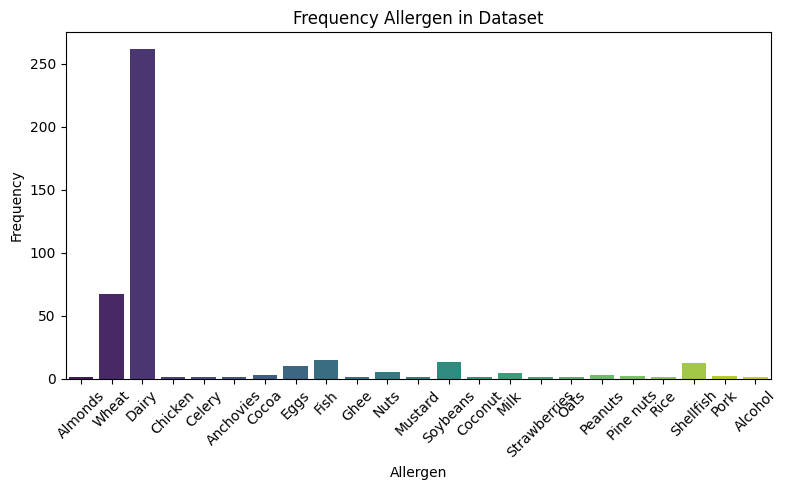

In [14]:
plt.figure(figsize=[8, 5])
sns.barplot(data=allergen_df, x='Allergen', y='Frequency', palette='viridis')
plt.title('Frequency Allergen in Dataset')
plt.xlabel('Allergen')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Modelling using Content Based Filtering

In [15]:
# Inisialization using TfidfVectorizer
tf = TfidfVectorizer()

# Count Allergens from dataframe
tf.fit(df['Allergens'])

# Mapping array from index feature integer to name feature
tf.get_feature_names_out()

array(['alcohol', 'almonds', 'anchovies', 'celery', 'chicken', 'cocoa',
       'coconut', 'dairy', 'eggs', 'fish', 'ghee', 'milk', 'mustard',
       'nuts', 'oats', 'peanuts', 'pine', 'pork', 'rice', 'shellfish',
       'soybeans', 'strawberries', 'wheat'], dtype=object)

In [16]:
# Fit_transform to matrix
tfidf_matrix = tf.fit_transform(df['Allergens'])

# Return shape of tfidf_matrix
tfidf_matrix.shape

(308, 23)

In [17]:
# Change vector to matrix using todense() function
tfidf_matrix.todense()

matrix([[0.        , 0.90902824, 0.        , ..., 0.        , 0.        ,
         0.37832323],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.28231558],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.46420137],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.46420137],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.40039612]])

In [18]:
# Create dataframe to see tfidf_matrix
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=df['Food Product']
).sample(10, axis=1).sample(10, axis=0)

,mustard,almonds,fish,oats,chicken,ghee,peanuts,nuts,celery,strawberries
Food Product,,,,,,,,,,
Pasta Carbonara,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Berry Smoothie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pineapple Upside-Down Cake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Vegetable Soup,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Egg Salad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cucumber Salad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mushroom Risotto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chicken Teriyaki,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Kheer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Calculate cosine similarity on matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.10680654, 0.17475465, ..., 0.21308965, 0.21308965,
        0.18380012],
       [0.10680654, 1.        , 0.        , ..., 0.13105128, 0.13105128,
        0.11303806],
       [0.17475465, 0.        , 1.        , ..., 0.21442339, 0.21442339,
        0.18495054],
       ...,
       [0.21308965, 0.13105128, 0.21442339, ..., 1.        , 1.        ,
        0.22552215],
       [0.21308965, 0.13105128, 0.21442339, ..., 1.        , 1.        ,
        0.22552215],
       [0.18380012, 0.11303806, 0.18495054, ..., 0.22552215, 0.22552215,
        1.        ]])

In [20]:
# Create dataframe from variable cosine_sim
cosine_sim_df = pd.DataFrame(cosine_sim, index=df['Food Product'], columns=df['Food Product'])
print('Shape:', cosine_sim_df.shape)

# Return similarity matrix
cosine_sim_df.sample(10, axis=1).sample(10, axis=0)

Shape: (308, 308)


Food Product,Ratatouille Pasta,Ratatouille,Pesto Pizza,Lentil Soup,Vanilla Ice Cream,Teriyaki Beef,Apple Cider,Ratatouille,Mushroom Risotto,Tuna Sandwich
Food Product,,,,,,,,,,
Coconut Curry,1.000000,1.000000,1.000000,1.000000,0.0,0.00000,1.000000,1.000000,0.419343,0.000000
Black Bean Soup,1.000000,1.000000,1.000000,1.000000,0.0,0.00000,1.000000,1.000000,0.419343,0.000000
Caesar Pasta Salad,0.419343,0.419343,0.419343,0.419343,0.0,0.00000,0.419343,0.419343,1.000000,0.000000
Caprese Skewers,1.000000,1.000000,1.000000,1.000000,0.0,0.00000,1.000000,1.000000,0.419343,0.000000
Spinach and Feta Stuffed Chicken,1.000000,1.000000,1.000000,1.000000,0.0,0.00000,1.000000,1.000000,0.419343,0.000000
Tiramisu,0.174755,0.174755,0.174755,0.174755,0.0,0.00000,0.174755,0.174755,0.416735,0.000000
Carrot Cake,0.419343,0.419343,0.419343,0.419343,0.0,0.00000,0.419343,0.419343,1.000000,0.000000
Sushi Rolls,0.000000,0.000000,0.000000,0.000000,0.0,0.71873,0.000000,0.000000,0.000000,0.468961
Caesar Salad Wrap,1.000000,1.000000,1.000000,1.000000,0.0,0.00000,1.000000,1.000000,0.419343,0.000000


In [21]:
def food_avoids(food_product, similarity_data=cosine_sim_df, items=df[['Food Product', 'Allergens']], k=10):
    """
    Avoids food products based on similarity of allergens.

    Args:
        food_product (str): The name of the food product to find avoids for.
        similarity_data (pd.DataFrame): The cosine similarity DataFrame.
        items (pd.DataFrame): DataFrame containing 'Food Product' and 'Allergens' columns.
        k (int): The number of avoids to return.

    Returns:
        pd.DataFrame: A DataFrame containing the top k avoids food products.
    """
    # Get the index of the food product in the items DataFrame
    try:
        index_val = items[items['Food Product'] == food_product].index[0]
    except IndexError:
        print(f"Food product '{food_product}' not found in the dataset.")
        return pd.DataFrame()  # Return an empty DataFrame if not found

    # Get the similarities for the given food product
    similarities = similarity_data.iloc[index_val].to_numpy()

    # Get the indices of the most similar items using argpartition
    # (excluding the item itself)
    index = similarities.argpartition(range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(items.iloc[index_val]['Food Product'], errors='ignore')  # Drop the current item

    # Return the top k avoids
    # Create DataFrame with 'Food Product' as column
    avoids_df = pd.DataFrame(closest, columns=['Food Product'])
    # Merge on 'Food Product' column
    return avoids_df.merge(items, on='Food Product').head(k)

### Testing

In [22]:
# Return food product to test
food_product = 'Mushroom Risotto'
df[df['Food Product'].eq(food_product)].head(1)

,Food Product,Main Ingredient,Sweetener,Fat/Oil,Seasoning,Allergens,Prediction
33,Mushroom Risotto,Mushrooms,Sugar,Butter,"Arborio rice, Parmesan cheese",Dairy,Contains


In [23]:
# Return result from avoid food product based on allergen
food_product = 'Mushroom Risotto'
food_avoids = food_avoids(food_product)
food_avoids

,Food Product,Allergens
0,Chicken Shawarma,Dairy
1,Chicken Shawarma,Dairy
2,Chicken Fajitas,Dairy
3,Mango Salsa,Dairy
4,Mango Salsa,Dairy
5,Lentil Curry,Dairy
6,Green Smoothie,Dairy
7,Sausage Pizza,Dairy
8,Beef and Broccoli,Dairy
9,Beef Burritos,Dairy
